## Modeling : Predicting AQI - PM 2.5 Indiana

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.decomposition import PCA
import pickle

In [2]:
# Load air data with power plant information
df = pd.read_csv('../data/pm2_5_pp_Indiana_mth_allpp.csv') # yaer 2018, 2016, 2014, 2012, 2010, 2009, 2007, 2005, 2004

# Load vehicle data
df_rv = pd.read_csv('../data/registered_vehicles.csv')

In [3]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

In [4]:
df.head(1)

,date,air_lat,air_long,air_type,aqi,pp_lat,pp_long,pp_boiler,fuel,distance,dir,state,year,month
0,2018-01,37.974436,-87.532289,pm2_5,38.3,41.9084,-89.0466,1.0,Gas,283.065534,NW,Illinois,2018,1


In [5]:
df_rv.head(1)

,year,state,automobile,bus,truck,motorcycle,all_mv
0,2017,Alabama,2065463,5682.0,2872743,112185.0,5056073.0


In [6]:
df_rv['year'].unique()

array([2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007,
       2006, 2005, 2004, 2003], dtype=int64)

In [7]:
df['year'].unique()

array([2018, 2016, 2014, 2012, 2010, 2009, 2007, 2005, 2004], dtype=int64)

In [8]:
df.shape

(2863638, 14)

In [9]:
# Drop rows of year 2018 as we don't have 2018 vehicle data
df.drop(df[df['year'] == 2018].index, axis=0, inplace=True)

In [10]:
df.shape

(2356394, 14)

In [11]:
df['date'] = pd.to_datetime(df['date'])

In [12]:
df = df.merge(df_rv, on=['state', 'year'], how='left')

In [13]:
# df_oz = df[df['air_type'] == 'ozone']
df_air = df[df['air_type'] == 'pm2_5']

In [14]:
df_air.shape

(2356394, 19)

In [15]:
df_air['distance'].min(), df_air['distance'].max()

(0.7547635207072424, 857.7132078390756)

In [16]:
df_air.head(1)

,date,air_lat,air_long,air_type,aqi,pp_lat,pp_long,pp_boiler,fuel,distance,dir,state,year,month,automobile,bus,truck,motorcycle,all_mv
0,2016-01-01,37.974436,-87.532289,pm2_5,33.818182,41.9084,-89.0466,0.0,Gas,283.065534,NW,Illinois,2016,1,4524709,34936.0,5402730,314807.0,10277182.0


In [17]:
df_50 = df_air[['air_lat', 'air_long', 'distance']][df_air['distance'] <= 50]
df_100 = df_air[['air_lat', 'air_long', 'distance']][df_air['distance'] <= 100]
df_150 = df_air[['air_lat', 'air_long', 'distance']][df_air['distance'] <= 150]

In [18]:
df_50.drop_duplicates(inplace=True)
df_100.drop_duplicates(inplace=True)
df_150.drop_duplicates(inplace=True)

In [19]:
df_50 = df_50.pivot_table(index=['air_lat', 'air_long'], values=['distance'], aggfunc='count')
df_100 = df_100.pivot_table(index=['air_lat', 'air_long'], values=['distance'], aggfunc='count')
df_150 = df_150.pivot_table(index=['air_lat', 'air_long'], values=['distance'], aggfunc='count')

In [20]:
df_50.reset_index(level=['air_lat', 'air_long'], inplace=True)
df_100.reset_index(level=['air_lat', 'air_long'], inplace=True)
df_150.reset_index(level=['air_lat', 'air_long'], inplace=True)

In [21]:
df_50.rename(columns = {'distance':'num_pp_50_mi'}, inplace = True)
df_100.rename(columns = {'distance':'num_pp_100_mi'}, inplace = True)
df_150.rename(columns = {'distance':'num_pp_150_mi'}, inplace = True)

In [22]:
df_air = df_air.merge(df_50, on=['air_lat', 'air_long'], how='left')
df_air = df_air.merge(df_100, on=['air_lat', 'air_long'], how='left')
df_air = df_air.merge(df_150, on=['air_lat', 'air_long'], how='left')
df_air.head()

,date,air_lat,air_long,air_type,aqi,pp_lat,pp_long,pp_boiler,fuel,distance,dir,state,year,month,automobile,bus,truck,motorcycle,all_mv,num_pp_50_mi,num_pp_100_mi,num_pp_150_mi
0,2016-01-01,37.974436,-87.532289,pm2_5,33.818182,41.908400,-89.046600,0.0,Gas,283.065534,NW,Illinois,2016,1,4524709,34936.0,5402730,314807.0,10277182.0,48,121,253
1,2016-01-01,37.974436,-87.532289,pm2_5,33.818182,42.362222,-89.803611,0.0,Gas,325.701240,NW,Illinois,2016,1,4524709,34936.0,5402730,314807.0,10277182.0,48,121,253
2,2016-01-01,37.974436,-87.532289,pm2_5,33.818182,41.301700,-89.623600,0.0,Wind,255.193694,NW,Illinois,2016,1,4524709,34936.0,5402730,314807.0,10277182.0,48,121,253
3,2016-01-01,37.974436,-87.532289,pm2_5,33.818182,39.569771,-90.436020,0.0,Gas,191.544466,NW,Illinois,2016,1,4524709,34936.0,5402730,314807.0,10277182.0,48,121,253
4,2016-01-01,37.974436,-87.532289,pm2_5,33.818182,39.068747,-88.755547,0.0,Oil,100.452799,NW,Illinois,2016,1,4524709,34936.0,5402730,314807.0,10277182.0,48,121,253


In [23]:
df_air.isnull().sum()

date             0
air_lat          0
air_long         0
air_type         0
aqi              0
pp_lat           0
pp_long          0
pp_boiler        0
fuel             0
distance         0
dir              0
state            0
year             0
month            0
automobile       0
bus              0
truck            0
motorcycle       0
all_mv           0
num_pp_50_mi     0
num_pp_100_mi    0
num_pp_150_mi    0
dtype: int64

In [24]:
df_air.corr()[['aqi']].unstack().sort_values(kind="quicksort", ascending = False)

aqi  aqi              1.000000
     automobile       0.185255
     bus              0.049150
     distance         0.032701
     month            0.032215
     pp_lat           0.025280
     air_lat         -0.000671
     pp_boiler       -0.004989
     num_pp_50_mi    -0.015591
     pp_long         -0.020678
     all_mv          -0.028668
     air_long        -0.055027
     num_pp_150_mi   -0.078686
     num_pp_100_mi   -0.078983
     motorcycle      -0.122736
     truck           -0.299397
     year            -0.580614
dtype: float64

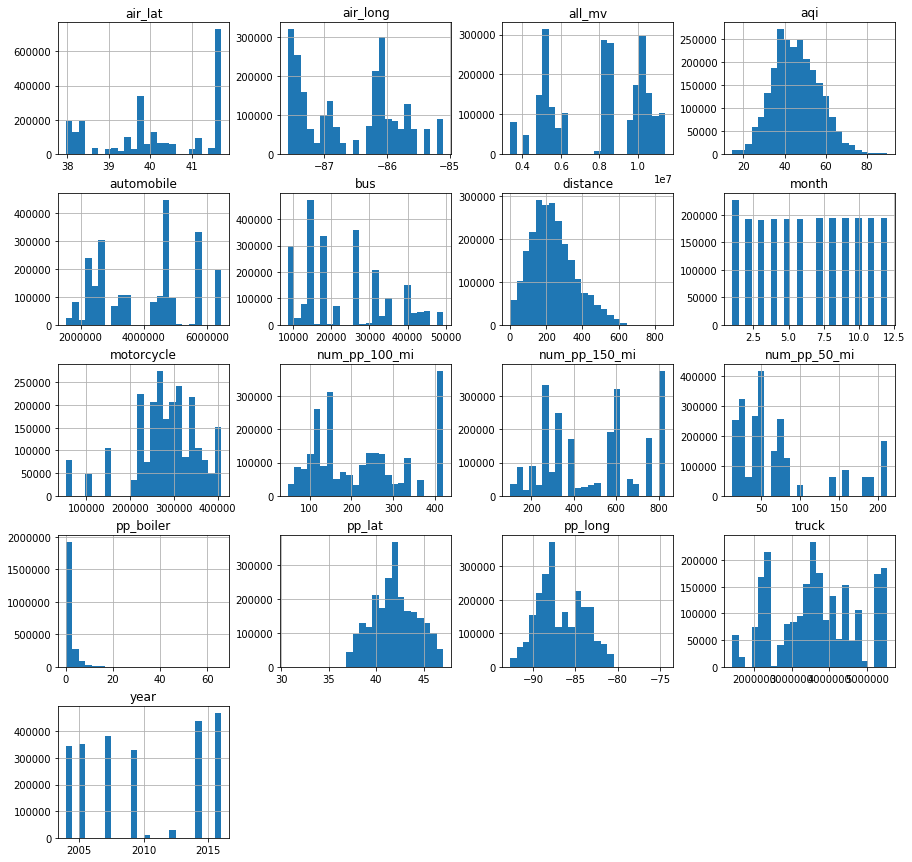

In [25]:
df_air.hist(figsize=(15,15), bins=24);

#### Preparing X and y

In [26]:
df_air.columns

Index(['date', 'air_lat', 'air_long', 'air_type', 'aqi', 'pp_lat', 'pp_long',
       'pp_boiler', 'fuel', 'distance', 'dir', 'state', 'year', 'month',
       'automobile', 'bus', 'truck', 'motorcycle', 'all_mv', 'num_pp_50_mi',
       'num_pp_100_mi', 'num_pp_150_mi'],
      dtype='object')

In [27]:
# 'date' column will be used only for timeseries modeling
X = df_air.drop(columns=['date', 'air_lat', 'air_long', 'air_type', 'aqi'], axis=1)
y = df_air['aqi']

In [28]:
# Make simulation data
simul = X.copy()

In [29]:
X = X.drop(columns=['pp_lat', 'pp_long'], axis=1)
X = pd.get_dummies(X, columns=['fuel', 'dir', 'month', 'state'], drop_first=True)

In [30]:
len(X.columns)

37

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1767295, 37), (589099, 37), (1767295,), (589099,))

#### Decision tree

In [33]:
dt2 = DecisionTreeRegressor(max_depth=20,
                           min_samples_leaf=10,
                           min_samples_split=30,
                           random_state=42)
dt2.fit(X_train, y_train)
dt2.score(X_train, y_train), dt2.score(X_test, y_test)

(0.9946499729980822, 0.9946305857520664)

#### Random Forest

In [34]:
rf1 = RandomForestRegressor(random_state=42, max_depth= 20, n_estimators= 150)
rf1.fit(X_train, y_train)
rf1.score(X_train, y_train), rf1.score(X_test, y_test)

(0.9953664474135994, 0.9953492359007841)

In [95]:
rf2 = RandomForestRegressor(random_state=42, max_depth= 20, n_estimators= 250)
rf2.fit(X_train, y_train)
rf2.score(X_train, y_train), rf2.score(X_test, y_test)

(0.995315105341456, 0.9952986809152871)

In [ ]:
rf3 = RandomForestRegressor(random_state=42, max_depth= 20, n_estimators= 150)
rf3.fit(X_train, y_train)
rf3.score(X_train, y_train), rf3.score(X_test, y_test)

In [35]:
df_result = pd.DataFrame()
df_result['features'] = X_train.columns
df_result['importance'] = rf1.feature_importances_
df_imp = df_result.sort_values(by='importance', ascending=False)
df_imp.reset_index(drop=True, inplace = True)

In [36]:
df_imp

,features,importance
0,year,4.934210e-01
1,num_pp_50_mi,7.452304e-02
2,num_pp_150_mi,6.785451e-02
3,month_2,5.918592e-02
4,num_pp_100_mi,5.679749e-02
5,month_10,4.484214e-02
6,month_5,3.479019e-02
7,month_9,3.375138e-02
8,month_4,3.243418e-02
9,month_11,2.542252e-02


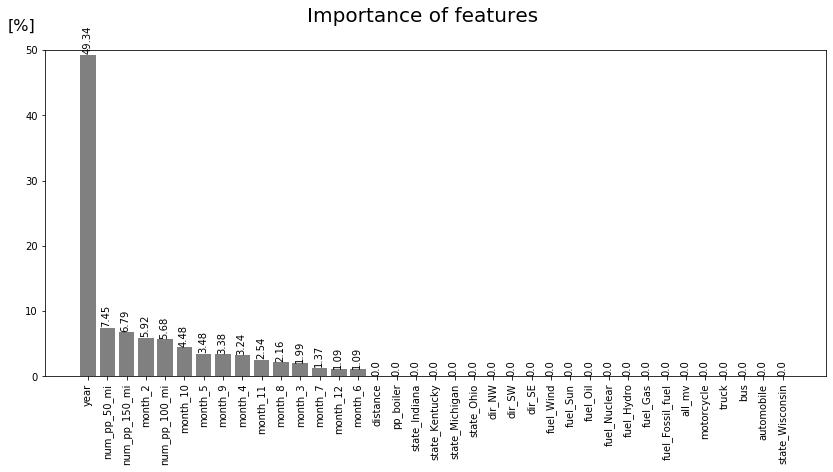

In [37]:
# Draw a barchart of performance of models
fig = plt.figure(figsize = (14, 6))
plt.bar(df_imp['features'], df_imp['importance'] * 100, color = 'gray')
plt.xticks(rotation=90)
plt.ylim(0, 50)

for width, height in enumerate(df_imp['importance']):
    plt.text(width-0.3, height * 100 + 0.4, round(height * 100, 2), rotation=90)

fig.suptitle('Importance of features', fontsize=20)
# plt.xlabel('[Model]', fontsize=16, position=(0.95,100))
plt.ylabel('[%]', fontsize=16, rotation=0, position=(0,1.05))
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=12)
fig.savefig('../img/feature_importance_pm2_5_Indiana.png');

Pickle a model

In [43]:
model_fn = './pickles/rf_pm2_5_Indiana_dsi.pickle'

with open(model_fn, 'wb') as f:
    pickle.dump(rf1, f)

Load and test picked model

In [44]:
model_fn = './pickles/rf_pm2_5_Indiana_dsi.pickle'
    
with open(model_fn, 'rb') as f:
    mdl = pickle.load(f)

In [40]:
mdl.score(X_train, y_train), mdl.score(X_test, y_test)

(0.9953664474135994, 0.9953492359007841)

In [41]:
rf1.predict(X_test.head())

array([55.75      , 39.72222222, 39.1       , 49.8       , 39.36363636])

In [42]:
mdl.predict(X_test.head())

array([55.75      , 39.72222222, 39.1       , 49.8       , 39.36363636])

Make simulation files

In [60]:
simul.columns

Index(['pp_lat', 'pp_long', 'pp_boiler', 'fuel', 'distance', 'dir', 'state',
       'year', 'month', 'automobile', 'bus', 'truck', 'motorcycle', 'all_mv',
       'num_pp_50_mi', 'num_pp_100_mi', 'num_pp_150_mi'],
      dtype='object')

In [64]:
X_train.columns

Index(['pp_boiler', 'distance', 'year', 'automobile', 'bus', 'truck',
       'motorcycle', 'all_mv', 'num_pp_50_mi', 'num_pp_100_mi',
       'num_pp_150_mi', 'fuel_Fossil_fuel', 'fuel_Gas', 'fuel_Hydro',
       'fuel_Nuclear', 'fuel_Oil', 'fuel_Sun', 'fuel_Wind', 'dir_NW', 'dir_SE',
       'dir_SW', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'state_Indiana', 'state_Kentucky', 'state_Michigan', 'state_Ohio',
       'state_Wisconsin'],
      dtype='object')

In [65]:
X['fuel'] = simul['fuel']
X['state'] = simul['state']
X['lat'] = simul['pp_lat']
X['long'] = simul['pp_long']

In [66]:
X[X['distance'] <= 50].to_csv('../data/simul/rf_pm_Indiana_allpp_50.csv', index=False)
X[(X['distance'] > 50) & (X['distance'] <= 100)].to_csv('../data/simul/rf_pm_Indiana_allpp_100.csv', index=False)
X[(X['distance'] > 100) & (X['distance'] <= 150)].to_csv('../data/simul/rf_pm_Indiana_allpp_150.csv', index=False)

In [67]:
pd.DataFrame(columns=X.columns).to_csv('../data/test/rf_pm_Indiana_allpp_columns.csv', index=False)